# XGB

## Estimando o melhor modelo do classificador para o dataset anotado tweetSentBR (sobreamostrado), com vetorizador Tfidf

### Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Carregando os dados para treinamento do modelo

In [2]:
# carregando dataset
tweets_df = pd.read_csv('')

In [3]:
tweets_df.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,que coisa linda O programa estava mostrando um...,False
1,865583716088766464,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,1,test,por mais com as irmãs galvão adorei elas,False
2,865063232201011200,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,1,test,mr CATRA USERNAME lançando sua nova música PPK...,False
3,864668391008763904,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,0,test,quem viu aquela lutadora modela barbuda tatuad...,False
4,865572794016378880,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,-1,test,tô passada com esse cara quanta merda pode sai...,False


In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15047 entries, 0 to 15046
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         15047 non-null  int64 
 1   hashtag    15047 non-null  object
 2   votes      15047 non-null  object
 3   hard       15047 non-null  int64 
 4   sentiment  15047 non-null  object
 5   group      15047 non-null  object
 6   text       15047 non-null  object
 7   repeat     15047 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 837.7+ KB


In [5]:
tweets_df.groupby(['sentiment']).count()

,id,hashtag,votes,hard,group,text,repeat
sentiment,,,,,,,
-,47,47,47,47,47,47,47
-1,4426,4426,4426,4426,4426,4426,4426
0,3926,3926,3926,3926,3926,3926,3926
1,6648,6648,6648,6648,6648,6648,6648


Como podemos observar, os dados estão desbalanceados e com algumas linhas apresentando a variável sentimento com o caracter traço '-'.

Para melhor trabalharmos com os dados, foi decidida a remoção dessas linhas.

In [6]:
# removendo as linhas com a variável sentimento como traço '-'
indexNames = tweets_df[ tweets_df['sentiment'] == '-' ].index #obtendo o valor para ajudar a remover a linha
tweets_df.drop(indexNames , inplace=True) #removendo a linha correspondente ao valor informado

In [7]:
# tranformando valores para adequar a os classificadores
tweets_df['sentiment'] = tweets_df['sentiment'].replace(['-1', '0', '1'], [3, 6, 9])
tweets_df['sentiment'] = tweets_df['sentiment'].replace([3, 6, 9], [0, 1, 2])

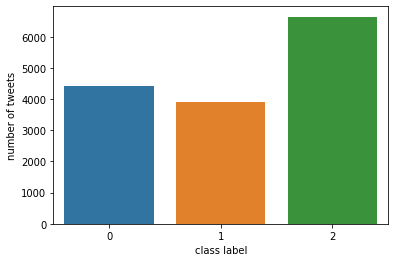

In [8]:
# Visualizando os dados graficamente
sns.countplot(x=tweets_df.sentiment)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

In [9]:
tweets_df.groupby(['sentiment']).count()

,id,hashtag,votes,hard,group,text,repeat
sentiment,,,,,,,
0,4426,4426,4426,4426,4426,4426,4426
1,3926,3926,3926,3926,3926,3926,3926
2,6648,6648,6648,6648,6648,6648,6648


## Efetuando a limpeza dos dados

In [10]:
# removendo as palavras USERNAME e NUMBER
tweets_df['text_clean'] = tweets_df['text'].str.replace('USERNAME', '').str.replace('NUMBER', '')

In [11]:
!python -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# importando a biblioteca de processamento de linguagen natural e a de expreções regulares (regex)
import nltk
import re

# usando as funções stopword e remover os caracteres indesejados
def Preprocessing(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower() # remove url e tranforma o texto em minusculo
    instancia = re.sub(r'[0-9]+', '', instancia) # remove números
    instancia = re.sub(r'[^\w\s]','', instancia) # remove pontuação
    instancia = re.sub('[!#$%^&*()]', '', instancia) #remove caractéres espaciais
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [13]:
# remover emojis utilizado regex (re)
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [14]:
# aplicando a função de limpeza de dados:
tweets_df['text_clean'] = [Preprocessing(i) for i in tweets_df['text_clean']]
tweets_df['text_clean'] = [remove_emoji(i) for i in tweets_df['text_clean']]
pd.set_option('display.max_colwidth', None) 

tweets_df.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat,text_clean
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de NUMBER anos que amor !,False,coisa linda programa mostrando familia adotou adolescente anos amor
1,865583716088766464,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,por mais com as irmãs galvão adorei elas,False,irmãs galvão adorei
2,865063232201011200,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,2,test,mr CATRA USERNAME lançando sua nova música PPK CHORA no USERNAME k k k 👅 😉 #MrCatra #PpkChora,False,mr catra lançando nova música ppk chora k k k mrcatra ppkchora
3,864668391008763904,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,1,test,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR,False,viu lutadora modela barbuda tatuada masterchefbr
4,865572794016378880,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,0,test,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos 😠,False,tô passada cara quanta merda pode sair boca alguém alguns minutos


# Lematização

In [15]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 9.0 MB/s 
     |████████████████████████████████| 1.2 MB 17.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.0
    Uninstalling spacy-3.4.0:
      Successfully uninstalled spacy-3.4.0
2022-07-28 15:58:24.045337: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [16]:
import spacy
nlp = spacy.load('pt_core_news_sm')

In [17]:
tweets_df['text_lemma'] = tweets_df['text_clean'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
tweets_df['text_lemma'] = [Preprocessing(i) for i in tweets_df['text_lemma']]
tweets_df.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat,text_clean,text_lemma
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de NUMBER anos que amor !,False,coisa linda programa mostrando familia adotou adolescente anos amor,coisa lindo programa mostrar familia adotar adolescente ano amor
1,865583716088766464,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,por mais com as irmãs galvão adorei elas,False,irmãs galvão adorei,irmã galvão ador
2,865063232201011200,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,2,test,mr CATRA USERNAME lançando sua nova música PPK CHORA no USERNAME k k k 👅 😉 #MrCatra #PpkChora,False,mr catra lançando nova música ppk chora k k k mrcatra ppkchora,mr catra lançar novo música ppk chorar k k k mrcatra ppkchora
3,864668391008763904,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,1,test,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR,False,viu lutadora modela barbuda tatuada masterchefbr,ver lutadora modelar barbuda tatuar masterchefbr
4,865572794016378880,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,0,test,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos 😠,False,tô passada cara quanta merda pode sair boca alguém alguns minutos,tô passado cara quanto merdo poder sair boca alguém algum minuto


## Lematização (outra forma)

In [18]:
!pip install simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 7.9 MB/s eta 0:00:00


In [19]:
import simplemma
from simplemma import text_lemmatizer

In [20]:
# teste
teste_lemma = text_lemmatizer('Sou o intervalo entre o que desejo ser e os outros me fizeram.', lang='pt')
teste_lemma

['ser',
 'o',
 'intervalo',
 'entre',
 'o',
 'que',
 'desejo',
 'ser',
 'e',
 'o',
 'outro',
 'me',
 'fazer',
 '.']

In [21]:
tweets_df['text_lemma_2'] = [text_lemmatizer(linha, lang='pt') for linha in tweets_df['text_clean']] #lematizando o texto
tweets_df['text_lemma_2'] = [' '.join(palavra) for palavra in tweets_df['text_lemma_2']] #juntando o texto novamente
tweets_df.head()

,id,hashtag,votes,hard,sentiment,group,text,repeat,text_clean,text_lemma,text_lemma_2
0,863044774588272640,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,que coisa linda O programa estava mostrando uma familia que adotou um adolescente de NUMBER anos que amor !,False,coisa linda programa mostrando familia adotou adolescente anos amor,coisa lindo programa mostrar familia adotar adolescente ano amor,coisar lindar programar mostrar familia adotar adolescente ano amor
1,865583716088766464,#encontro,"[1, 1, 1, 1, 1, 1, 1]",0,2,test,por mais com as irmãs galvão adorei elas,False,irmãs galvão adorei,irmã galvão ador,irmão galvão adorar
2,865063232201011200,#TheNoite,"[1, 0, 1, 1, 1, 0, 0]",2,2,test,mr CATRA USERNAME lançando sua nova música PPK CHORA no USERNAME k k k 👅 😉 #MrCatra #PpkChora,False,mr catra lançando nova música ppk chora k k k mrcatra ppkchora,mr catra lançar novo música ppk chorar k k k mrcatra ppkchora,mr catra lançar novo músico ppk chorar k k k mrcatra ppkchora
3,864668391008763904,#masterchefbr,"[0, 0, 0, 0, 0, 0, 0]",0,1,test,quem viu aquela lutadora modela barbuda tatuada #MasterChefBR,False,viu lutadora modela barbuda tatuada masterchefbr,ver lutadora modelar barbuda tatuar masterchefbr,ver lutador modelar barbudo tatuado masterchefbr
4,865572794016378880,#encontro,"[-1, -1, -1, -1, -1, -1, -1]",0,0,test,tô passada com esse cara quanta merda pode sair da boca de alguém em alguns minutos 😠,False,tô passada cara quanta merda pode sair boca alguém alguns minutos,tô passado cara quanto merdo poder sair boca alguém algum minuto,tô passado caro quanto merda poder sair bocar alguém algum minuto


## Trabalhando no equilibrio dos dados

### Iniciando o trabalho de balanceamento dos dados

In [22]:
# criando a lista sentimentos (com as quantidades das classes)
sentimentos = []
sentimentos.append(tweets_df.loc[tweets_df['sentiment'] == 0]['sentiment'].count())
sentimentos.append(tweets_df.loc[tweets_df['sentiment'] == 1]['sentiment'].count())
sentimentos.append(tweets_df.loc[tweets_df['sentiment'] == 2]['sentiment'].count())

sentimentos

[4426, 3926, 6648]

In [23]:
# colacando a lista sentimento em ordem (minoria, meio, maioria)
sentimentos.sort()
sentimentos

[3926, 4426, 6648]

In [24]:
# instanciando as classes de sentimentos
sent = [0, 0, 0]
for i in range(len(sentimentos)):
  for j in range(len(sentimentos)):
    if sentimentos[i] == tweets_df.loc[tweets_df['sentiment'] == j]['sentiment'].count():
      sent[i] = tweets_df.loc[tweets_df['sentiment'] == j]

minoria = sent[0]
meio = sent[1]
maioria = sent[2]

In [25]:
print('Maioria \n{}\n'.format(maioria['sentiment'].count()))
print('Meio \n{}\n'.format(meio['sentiment'].count()))
print('Minoria \n{}'.format(minoria['sentiment'].count()))

Maioria 
6648

Meio 
4426

Minoria 
3926


## Igualar a quantidade de tweets entre positivo, negativo e neutro

#### Oversampling (Criando datasets reorganizados para maioria)

In [26]:
from sklearn.utils import resample

menor_maior = resample(minoria, replace=True, n_samples=len(maioria), random_state=123)
meio_maior = resample(meio, replace=True, n_samples=len(maioria), random_state=123)

In [27]:
print(menor_maior.count(), meio_maior.count(), maioria.count())

id              6648
hashtag         6648
votes           6648
hard            6648
sentiment       6648
group           6648
text            6648
repeat          6648
text_clean      6648
text_lemma      6648
text_lemma_2    6648
dtype: int64 id              6648
hashtag         6648
votes           6648
hard            6648
sentiment       6648
group           6648
text            6648
repeat          6648
text_clean      6648
text_lemma      6648
text_lemma_2    6648
dtype: int64 id              6648
hashtag         6648
votes           6648
hard            6648
sentiment       6648
group           6648
text            6648
repeat          6648
text_clean      6648
text_lemma      6648
text_lemma_2    6648
dtype: int64


In [28]:
# juntando os dataframes
tweets_df_equilibrado_maior = pd.concat([menor_maior, meio_maior, maioria])

# resetando o index
tweets_df_equilibrado_maior = tweets_df_equilibrado_maior.reset_index()

# removendo as colunas Unnamed: 0 e index
tweets_df_equilibrado_maior.drop(columns=['index'], inplace=True)

In [29]:
tweets_df_equilibrado_maior.groupby(['sentiment']).count()

,id,hashtag,votes,hard,group,text,repeat,text_clean,text_lemma,text_lemma_2
sentiment,,,,,,,,,,
0,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648
1,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648
2,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648


# Machine Learning - Utils

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Vetorizadores
from sklearn.feature_extraction.text import TfidfVectorizer

# Classificadores
import xgboost as xgb

In [31]:
# Tokenização especial para tweets
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

# Machine Learning - Construindo modelo com dados oversampling

In [32]:
X = tweets_df_equilibrado_maior['text_lemma_2']
y = tweets_df_equilibrado_maior['sentiment']

In [33]:
X.shape, y.shape

((19944,), (19944,))

### Separando dados para o treino e para o teste

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14958,), (14958,), (4986,), (4986,))

In [35]:
parameters = {'modelo__objective':['binary:logistic', 'binary:logitraw', 'binary:hinge'],
              'modelo__learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5],
              'modelo__max_depth':[1, 2, 4, 6]}

In [36]:
modelo = Pipeline(steps=[
             ('vectorizer' , TfidfVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)),
            ('modelo', xgb.XGBClassifier())
            ])

In [37]:
!pip install searchgrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 48.8 MB/s eta 0:00:00
  Created wheel for searchgrid: filename=searchgrid-0.2.0-py3-none-any.whl size=5747 sha256=dc1f838b994ffe7340285bc0f14cecb8538c686612324407b3f4b641ed8b5372
  Stored in directory: /root/.cache/pip/wheels/2b/dc/34/7c849b7da28bce9e557817b9b966fb4037c5cf3b3e035bacf9
Successfully built searchgrid
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [38]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(modelo, parameters, refit = 'accuracy', verbose=3)
clf.fit(X_train, y_train).best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logistic;, score=0.414 total time=   4.2s
[CV 2/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logistic;, score=0.430 total time=   6.5s
[CV 3/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logistic;, score=0.417 total time=   6.1s
[CV 4/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logistic;, score=0.426 total time=   8.0s
[CV 5/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logistic;, score=0.435 total time=   7.1s
[CV 1/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logitraw;, score=0.414 total time=   3.8s
[CV 2/5] END modelo__learning_rate=0.01, modelo__max_depth=1, modelo__objective=binary:logitraw;, score=0.430 total time=   3.0s
[CV 3/5] END modelo__learning_rate=

0.697954581212443

In [39]:
# Imprime colunas de interesse.
df = pd.DataFrame(clf.cv_results_)[['params','rank_test_score','mean_test_score']]

In [40]:
df.sort_values(by='rank_test_score', inplace=True)
df

,params,rank_test_score,mean_test_score
59,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 6, 'modelo__objective': 'binary:hinge'}",1,0.697955
57,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 6, 'modelo__objective': 'binary:logistic'}",1,0.697955
58,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 6, 'modelo__objective': 'binary:logitraw'}",1,0.697955
45,"{'modelo__learning_rate': 0.3, 'modelo__max_depth': 6, 'modelo__objective': 'binary:logistic'}",4,0.683982
46,"{'modelo__learning_rate': 0.3, 'modelo__max_depth': 6, 'modelo__objective': 'binary:logitraw'}",4,0.683982
47,"{'modelo__learning_rate': 0.3, 'modelo__max_depth': 6, 'modelo__objective': 'binary:hinge'}",4,0.683982
56,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 4, 'modelo__objective': 'binary:hinge'}",7,0.680305
55,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 4, 'modelo__objective': 'binary:logitraw'}",7,0.680305
54,"{'modelo__learning_rate': 0.5, 'modelo__max_depth': 4, 'modelo__objective': 'binary:logistic'}",7,0.680305
44,"{'modelo__learning_rate': 0.3, 'modelo__max_depth': 4, 'modelo__objective': 'binary:hinge'}",10,0.653563


In [41]:
# salvando o relatório consolidado em excel
df.to_excel("repost_xgb.xlsx")